# Multi-Level Models (Hierarchical Models)

So far, we haven't considered the probability distribution of the fitting parameters $D_0,k_1,k_2$, and $k_3$. But to use a hierarchical model to combine our inference from different patch data and allow us to model our serum estradiol concentration, we will need to introduce hyperparameters that connect different studies. This way, our fitting parameters are given a "probabilistic specification" in terms of hyperparameters that are common for all. In our case, the hyperparameters would be the parameters of the distribution ([hyperprior](https://en.wikipedia.org/wiki/Hyperprior)) we choose to use in order to model our fitting parameters.

In [ ]:
#https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-hierarchical-binomial-model.html
#https://github.com/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%203.%20Hierarchical%20modelling.ipynb
#https://storopoli.io/Bayesian-Julia/

# Before and After Patch Removal

We can see from [3_Steady-State_Multi-Dose_3-Compartment](3_Steady-State_Multi-Dose_3-Compartment) that the decay after patch removal is not captured when the serum Estradiol solution didn't consider measurement after patch removal as a separate process.

After patch removal, the estradiol concentration within the depot $d_0$ (and thus $D(t_0)$) is zero.

We then [evolve](https://discord.com/channels/438306949285806082/1201973466845151362/1206123175331627029) our solution $E_2(t)$ with the initial condition at patch removal $t_{\rm rem}$ to be given by $A_{\rm eff}(t_{\rm rem})$ and $E_2(t_{\rm rem})$. i.e., we have for $E_2(t)$ after $t_{\rm rem}$

$$E_2^{t_{\rm rem}}(t)=\frac{k_2A_{\rm eff}(t_{\rm rem})}{k_2-k_3}\left[-\frac{e^{-k_2(t-T\operatorname{floor}(t/T))}}{1-e^{-k_2T}}+\frac{e^{-k_3(t-T\operatorname{floor}(t/T))}}{1-e^{-k_3T}}\right]+E_2(t_{\rm rem})\frac{e^{-k_3(t-T\operatorname{floor}(t/T))}}{1-e^{-k_3T}}.$$

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az

In [16]:
# import and visualize data

MylanTDPDays100 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_100mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays50 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_50mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays25 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_25mcg.csv', delimiter=',', skip_header=True)

H2003aN30Estradot100 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_100mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot50 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot37_5 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_37.5mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot25 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_25mcg.csv', delimiter=',', skip_header=True)

H2003bN11Estradot100 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_100mcg.csv', delimiter=',', skip_header=True)
H2003bN11Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_50mcg.csv', delimiter=',', skip_header=True)

# exclude n = 30 study from H2003b due to the initial measurement being higher than the second measurement
#H2003bN30Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n30/H2003b_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)

# convert Mylan data from days to hrs, Estradot data is already in hrs
# https://stackoverflow.com/questions/10394659/how-to-add-a-calculated-computed-column-in-numpy

MylanTDP100 = np.vstack((MylanTDPDays100[:,0]*24, MylanTDPDays100[:,1])).T
MylanTDP50 = np.vstack((MylanTDPDays50[:,0]*24, MylanTDPDays50[:,1])).T
MylanTDP25 = np.vstack((MylanTDPDays25[:,0]*24, MylanTDPDays25[:,1])).T

In [46]:
# fitting using single-dose model
# improved, now take patch removal into account, assume removal time t_{\rm rem} = 3.5 days

def E2Dose(t, d0, k1, k2, k3):
    summation = 0
    innerFunc1 = pm.math.exp(-k1 * t) / ((k1 - k2) * (k1 - k3))
    innerFunc2 = pm.math.exp(-k2 * t) / ((k1 - k2) * (k2 - k3))
    innerFunc3 = pm.math.exp(-k3 * t) / ((k1 - k3) * (k2 - k3))
    summation = d0 * (innerFunc1 - innerFunc2 + innerFunc3)
    return k1 * k2 * summation

# A_{\rm eff}(t_0) term

def AEff(t, Aeff0, k2, k3):
    summationEff = 0
    innerFunc1Eff = pm.math.exp(-k2 * t)
    innerFunc2Eff = pm.math.exp(-k3 * t)
    summationEff = Aeff0 *(-innerFunc1Eff + innerFunc2Eff)
    return k2 * summationEff / (k2 - k3)

# E2(t_0) term

def E2(t, E20, k3):
    return E20 * pm.math.exp(-k3 * t)

def E2Full(t, d0, Aeff0, E20, k1, k2, k3):
    if t <= 3.5*24:
        return E2Dose(t, d0, k1, k2, k3) + AEff(t, Aeff0, k2, k3) + E2(t, E20, k3)
    else:
        return AEff(t, Aeff0, k2, k3) + E2(t, E20, k3)

In [21]:
MylanTDP100

array([[2.66453526e-14, 3.41296928e+00],
       [1.97578692e+00, 4.84641638e+00],
       [3.95157385e+00, 2.77815700e+01],
       [8.13559322e+00, 8.43003413e+01],
       [1.19709443e+01, 1.00682594e+02],
       [2.39418886e+01, 9.88395904e+01],
       [3.57966102e+01, 1.01296928e+02],
       [4.76513317e+01, 6.87372014e+01],
       [5.98547215e+01, 6.30034130e+01],
       [7.21743341e+01, 3.67918089e+01],
       [8.40290557e+01, 3.67918089e+01],
       [8.60048426e+01, 2.65529010e+01],
       [8.79806295e+01, 1.93856655e+01],
       [9.18159806e+01, 1.44709898e+01],
       [9.60000000e+01, 8.73720137e+00],
       [1.01811138e+02, 7.09897611e+00],
       [1.08087167e+02, 6.27986348e+00],
       [1.20058111e+02, 4.64163823e+00]])

In [29]:
MylanTDP100[0:11,0]

array([2.66453526e-14, 1.97578692e+00, 3.95157385e+00, 8.13559322e+00,
       1.19709443e+01, 2.39418886e+01, 3.57966102e+01, 4.76513317e+01,
       5.98547215e+01, 7.21743341e+01, 8.40290557e+01])

In [68]:
# https://github.com/obscode/FlyingCircus/blob/master/MoreNotebooks/ModelFitting/Pymc.ipynb
# https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html#deterministic-transforms
# LaTeX needs to be treated as raw string literal for az to work, https://lightrun.com/answers/arviz-devs-arviz-latex-label-compatibility-issues-while-using-bokeh-as-backend, https://stackoverflow.com/questions/2081640/what-exactly-do-u-and-r-string-prefixes-do-and-what-are-raw-string-literals

Mylan100Model = pm.Model()

with Mylan100Model:
    # priors
    d0 = pm.Gamma(r"$d(t_0)$", alpha=1, beta=100)    # https://homepage.divms.uiowa.edu/~mbognar/applets/gamma.html, based on https://discord.com/channels/438306949285806082/1201973466845151362/1201999987731599462
    Aeff0 = pm.Gamma(r"$A_{\rm eff}(t_0)$", alpha=1, beta=100)
    E20 = pm.Gamma(r"$E_2(t_0)$", alpha=1, beta=100)
    k1 = pm.LogNormal(r"$k_1$", mu=1/(100/24), sigma=0.1)    # https://homepage.divms.uiowa.edu/~mbognar/applets/lognormal.html
    k2 = k1 + pm.Gamma(r"$k_2$", alpha=1, beta=1)
    k3 = pm.LogNormal(r"$k_3$", mu=1/37, sigma=0.1)    # https://homepage.divms.uiowa.edu/~mbognar/applets/lognormal.html

    # likelihood, https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/GLM_linear.html
    tInBefore = MylanTDP100[0:11,0]
    yInBefore = MylanTDP100[0:11,1]

    yHatBefore = pm.Deterministic(r"$\hat E_2$", E2Full(tInBefore[i], d0, Aeff0, E20, k1, k2, k3))

    Likelihood = pm.Normal(r"$\hat Y_{\rm rem}$", mu = yHatBefore,
                           observed = yInBefore, sigma=np.sqrt(yInBefore))

In [73]:
with Mylan100Model:
    sampleMylan100 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$d(t_0)$, $A_{\rm eff}(t_0)$, $E_2(t_0)$, $k_1$, $k_2$, $k_3$]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 20 seconds.


In [76]:
az.summary(sampleMylan100)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$d(t_0)$,0.010,0.010,0.000,0.028,0.000,0.000,15295.0,8539.0,1.0
$A_{\rm eff}(t_0)$,0.010,0.010,0.000,0.029,0.000,0.000,15620.0,9027.0,1.0
$E_2(t_0)$,0.011,0.011,0.000,0.031,0.000,0.000,14915.0,9082.0,1.0
$k_1$,1.277,0.128,1.046,1.521,0.001,0.001,22894.0,14611.0,1.0
$k_2$,0.989,0.985,0.000,2.763,0.006,0.005,15627.0,9383.0,1.0
$k_3$,1.033,0.103,0.840,1.226,0.001,0.000,23503.0,14065.0,1.0
$\hat E_2$,0.011,0.011,0.000,0.031,0.000,0.000,14915.0,9082.0,1.0


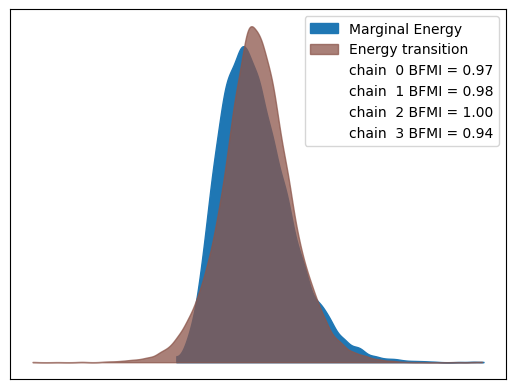

In [78]:
# https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html#deterministic-transforms
az.plot_energy(sampleMylan100);

Sampling: [$\hat Y_{\rm rem}$]
INFO:pymc.sampling.forward:Sampling: [$\hat Y_{\rm rem}$]


/home/ubuntu/venv310/lib/python3.10/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/home/ubuntu/venv310/lib/python3.10/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


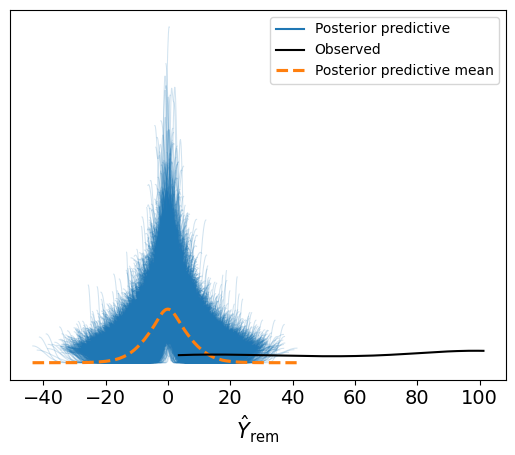

In [83]:
with Mylan100Model:
    sampleMylan100.extend(pm.sample_posterior_predictive(sampleMylan100))

fig, ax = plt.subplots()
az.plot_ppc(sampleMylan100, ax=ax)
ax.legend(fontsize=10);